# Part 2: Data Exploration & Feature Selection

#### Concepts Covered
Part 2 demonstrates assessing the relationship between features, specifically utilizing the Yellowbrick library to assess colinearity and class separation. This notebook demonstrates multiple approaches to scaling features using the sklearn library. Lastly, this notebook covers feature selection using feature importance and feature elimination techniques.

#### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

from yellowbrick.features import Rank2D, RadViz
from yellowbrick.model_selection import FeatureImportances

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Feature Relationships

There are over 800 variables on the dataset, including many indicator variables and variables which may not be helpful in predicting the income classification target. For the sake of this exercise, I must apply some subject matter expertise and significantly reduce the number of variables to 17.

In [2]:
conn = sqlite3.connect('../data/ce_intrvw_data.db')

wng_fmly_df = pd.read_sql('''select * from final_family_data''', conn)

conn.close()

In [3]:
columns = ['inc_class_encode','NO_EARNR','AGE_REF','MARITAL1','AS_COMP1','AS_COMP2',
           'AS_COMP3','AS_COMP4','AS_COMP5','PERSOT64','BLS_URBN','CUTENURE',
           'FAM_SIZE','FAM_TYPE','HIGH_EDU','VEHQ','VEHQL','INC_HRSQ']

wng_fmly_df = wng_fmly_df[columns]

In [4]:
wng_fmly_df.describe()

,inc_class_encode,NO_EARNR,AGE_REF,MARITAL1,AS_COMP1,AS_COMP2,AS_COMP3,AS_COMP4,AS_COMP5,PERSOT64,BLS_URBN,CUTENURE,FAM_SIZE,FAM_TYPE,HIGH_EDU,VEHQ,VEHQL,INC_HRSQ
count,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000,5899.000000
mean,0.400068,1.254111,52.312765,2.299203,0.904052,1.016443,0.222750,0.210375,0.051026,0.420241,1.067469,2.370571,2.404645,5.253094,13.813697,1.829293,0.079166,49.678929
std,0.489953,0.967608,17.677242,1.587341,0.648928,0.636225,0.549254,0.544389,0.232798,0.686944,0.250854,1.333626,1.414880,3.138196,1.691453,1.450500,0.315215,39.894660
min,0.000000,0.000000,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,37.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,12.000000,1.000000,0.000000,10.000000
50%,0.000000,1.000000,53.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,6.000000,14.000000,2.000000,0.000000,40.000000
75%,1.000000,2.000000,66.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,3.000000,8.000000,15.000000,2.000000,0.000000,80.000000
max,1.000000,6.000000,88.000000,5.000000,5.000000,5.000000,4.000000,5.000000,2.000000,4.000000,2.000000,6.000000,9.000000,9.000000,16.000000,13.000000,4.000000,265.000000


#### 2DRank

2DRank will use a inform me as to the colinearity between our features. Expected results arise, such as the positive relationship between family size and and the number of household members (the various AS_COMP variables), both of which are describing the make of up the household. In addition, the positive relationship between AGE_REF and PERSONOT64, if the person taking the survey is over 64, then they are included in the household and count towards PERSONOT64. The most heavily correlated features are the number of income earners and the total number of working hours by earners in the household.

In [5]:
feature_list = columns[1:]
target_list = columns[0]

features = wng_fmly_df[feature_list]
target = wng_fmly_df[target_list]

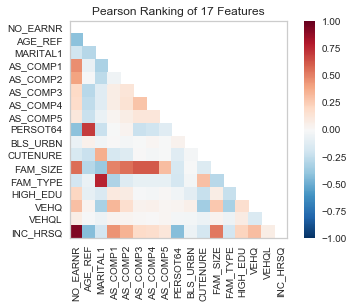

In [6]:
viz = Rank2D(features=feature_list, algorithm='pearson')

viz.fit(features, target)
viz.transform(features)
viz.poof()

#### RadViz

Using the RadViz visualizer, we can assess the separability of the two classes, at least or below 70k income. Classes do not seem demonstrably separated on this chart and both are pulled towards the number of earners in the household, and the number of hours worked by the household.

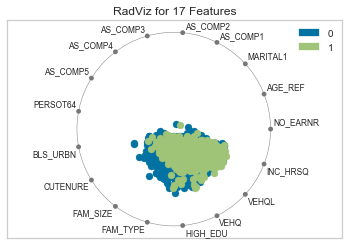

In [7]:
viz = RadViz()

viz.fit(features, target)
viz.transform(features)
viz.show()

### Feature Scaling (Standardization)

Before explicit feature and model selection, we will need assess the need for preprocessing and re-scaling of our features. Standardizations was performed on the features, not the target since the target is binary (categorical) [StandardScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), [Min-Max](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Ideally, (1) pick the scalar that gives you the *least amount of variance* in your features, and (2) *scale all features*. Lastly, be sure to understand the scaler you chose, even if you don't understand the scaler you did not choose. StandardScaler is intuitive for those coming from a basic background in statistics.

*Before Standardization*

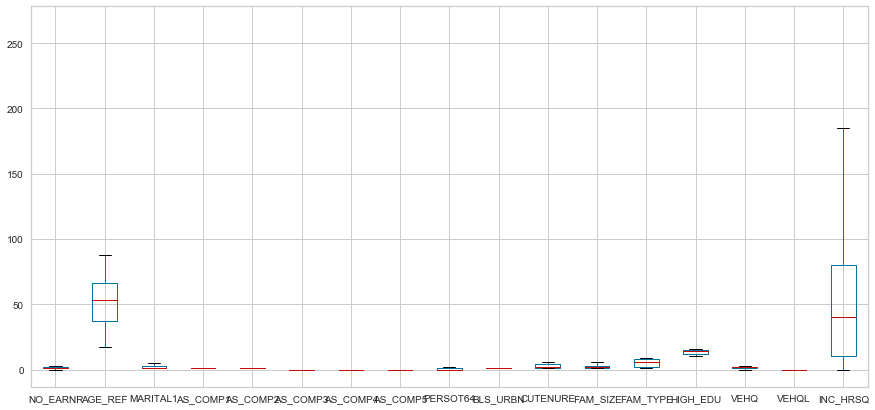

In [8]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,1,1)

features.boxplot(ax=ax1)

*After Standardization*

It is clear that Standard Scaler is preferrable to Min-Max Scaler, despite the wide whiskers around the total number of work hours by the household and a few other features.

In [9]:
stnd_scaler = StandardScaler()
mm_scaler = MinMaxScaler(feature_range=(0,1))

stnd_scaler_df= pd.DataFrame(stnd_scaler.fit_transform(features), columns=feature_list)
mm_scaler_df = pd.DataFrame(mm_scaler.fit_transform(features), columns=feature_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


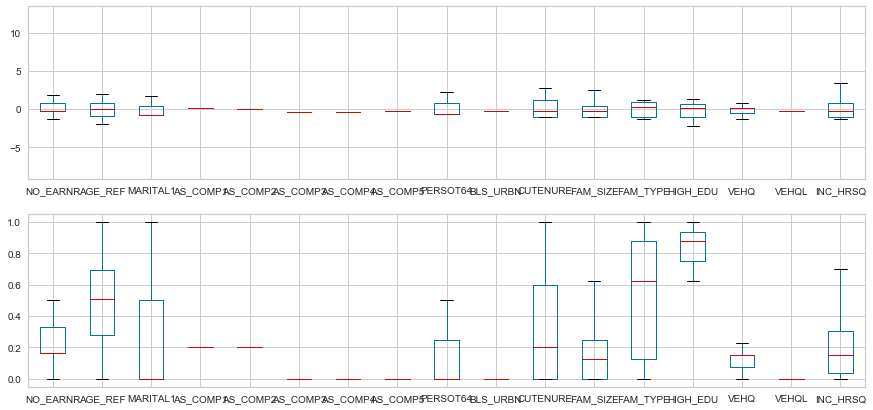

In [10]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


stnd_scaler_df.boxplot(ax=ax1)
mm_scaler_df.boxplot(ax=ax2)

### Feature Importance and Selection

To determine feature importance with the goal of selection, I will use [recursive feature elimination and cross-validated (rfecv)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).

Feature elimination with the Random Forest Classifier (RFC) suggests about 10 of the 17 features, depending on the run. This means feature elimination is optimal. Feature elimination with Gradient Boosting Classifier (GBC) suggests 6 features. Both elimination charts chart and the relative importance charts for each classifier are below.

The overlap is a solid indicator of features to include: INC_HRSQ, VEHQ, HIGH_EDU, FAM_TYPE, CUTENURE, AGE_REF. The features consistently recommended by RFC not GBC are NO_EARNER, MARITAL1, and FAM_SIZE. A part of me sees that what GBC excluded are correlated with the other features and I think that GBC is on to something and RFC is simply over-fitting. For the time being, since GBC suggested a subset of RFC, I will use the complete list suggested by the latter for modeling.

- NO_EARNR
- AGE_REF
- MARITAL1
- AS_COMP1
- CUTENURE
- FAM_SIZE
- FAM_TYPE
- HIGH_EDU
- VEHQ
- INC_HRSQ

*Feature Elimination and Importance with Random Forest Classifier*

In [11]:
rfecv = RFECV(estimator=RandomForestClassifier(n_estimators=10),
              step=1,
              cv=StratifiedKFold(12),
              scoring='accuracy',
              verbose=10,
              n_jobs=-1)

In [12]:
rfecv.fit(stnd_scaler_df, target)
print(rfecv.n_features_)

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
11


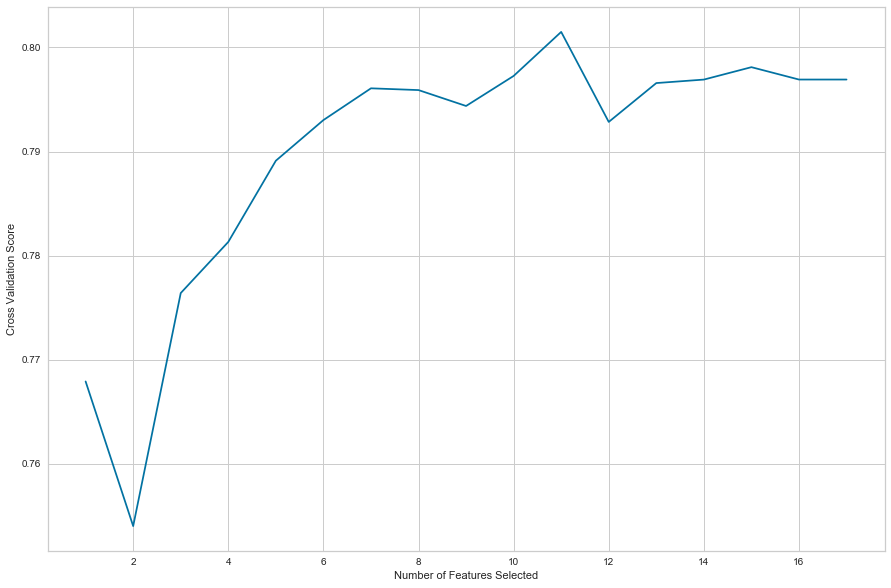

In [13]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.show()

In [14]:
for index in np.where(rfecv.support_)[0]:
    print(stnd_scaler_df.columns[index])

NO_EARNR
AGE_REF
MARITAL1
AS_COMP1
PERSOT64
CUTENURE
FAM_SIZE
FAM_TYPE
HIGH_EDU
VEHQ
INC_HRSQ


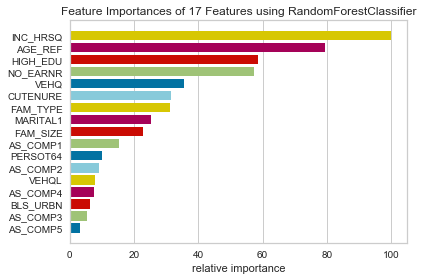

In [15]:
viz = FeatureImportances(RandomForestClassifier(n_estimators=10))
viz.fit(stnd_scaler_df, target)
viz.poof()

*Feature Elimination and Importance with Gradient Boosting Classifier*

In [16]:
rfecv = RFECV(estimator=GradientBoostingClassifier(),
              step=1,
              cv=StratifiedKFold(12),
              scoring='accuracy',
              verbose=10,
              n_jobs=-1)

In [17]:
rfecv.fit(stnd_scaler_df, target)
print(rfecv.n_features_)

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
6


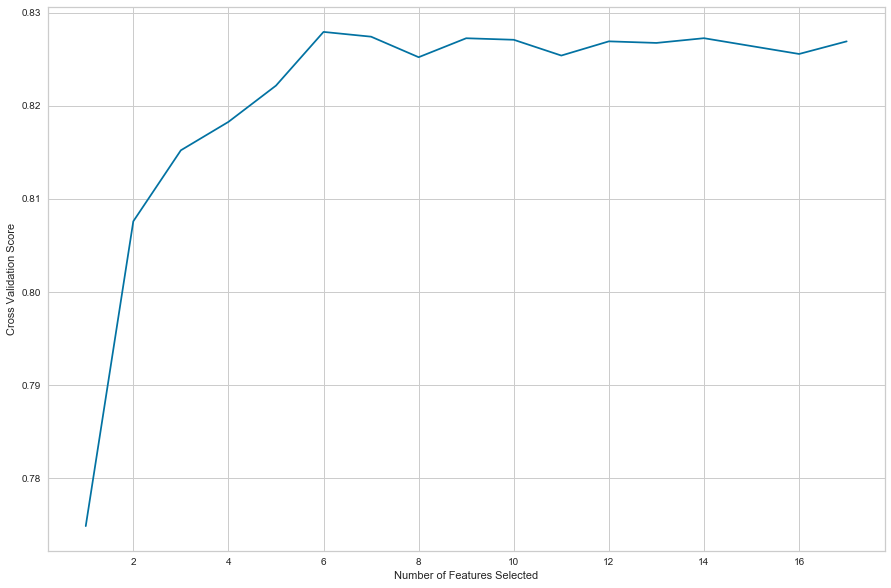

In [18]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.show()

In [19]:
for index in np.where(rfecv.support_)[0]:
    print(stnd_scaler_df.columns[index])

AGE_REF
CUTENURE
FAM_TYPE
HIGH_EDU
VEHQ
INC_HRSQ


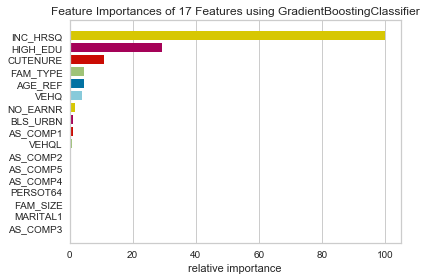

In [20]:
viz = FeatureImportances(GradientBoostingClassifier())
viz.fit(stnd_scaler_df, target)
viz.poof()